In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from IPython.display import Image
rc('animation', html='html5')
import cmocean as cm
from cartopy import crs, feature

sys.path.append('/Users/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [4]:
outfile = '/Users/jvalenti/Desktop/Iona_2019_repeat20190101_1n_20190116_1n.nc'
data = xr.open_dataset(outfile)
time = data.time[0,:]
Lat,Lon,Age,Z = order_data_bytime(data)

In [5]:
paths = path(1)
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [6]:
def order_data_bytime(data):
    DS= data.to_dataframe()
    lon = np.array(DS.sort_values(by='time').lon)
    lat = np.array(DS.sort_values(by='time').lat)
    z = np.array(DS.sort_values(by='time').z)
    age = np.array(DS.sort_values(by='time').tau)/3600
    T = np.array(DS.sort_values(by='time').time)

    Tint = []
    for ti in T:
        try:
            Tint.append(int(ti))
        except TypeError:
            pass
    Tint = np.array(Tint)

    Age = []
    Z = []
    Lat = []
    Lon = []
    t = time[0]
    while int(t) < int(time[-1]):    
        Lat.append(lat[np.where(Tint==int(t))])
        Lon.append(lon[np.where(Tint==int(t))])
        Age.append(age[np.where(Tint==int(t))])
        Z.append(z[np.where(Tint==int(t))])
        t+=np.timedelta64(2, 'h')

    return Lat,Lon,Age,Z

In [7]:
def scatter_particles(ax, N ,n,nmin, nmax,yvar,lon,Z,HD=1,colors='b'):
    '''scatter_particles(ax, N ,n,nmin, nmax,yvar,lon,HD=0,colors=colores)
    Use this function to scatter particles with different colours for each deploy location
    N= number of deploying sites,n=number of particles oper location, nmin,max=time min,max, yvar is the variable to plot on the yaxis, 
    Keep HD to 0 unless you want to plot with cartopy (only works for maps so yvar= latitude)
    '''
    
    scatter=[]
    #N is the number of stations, n the number of particles
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate, lon is the longitud array
    #HD (1 for cartopy plot) 0 otherwise
    if HD == 0:
        if nmin==nmax:
            scatter.append(ax.scatter(lon[nmin], yvar[nmin],s=4,c=Z[nmin],cmap=cmocean.cm.tempo,vmin=0,vmax=150,alpha=0.5))
        else:
            
            scatter.append(ax.scatter(lon[:, nmin:nmax], yvar[:, nmin:nmax],s=1,color=colors))
    else:
        if nmin==nmax:
            scatter.append(ax.scatter(lon[nmin], yvar[nmin],s=4,c=Z[nmin],cmap=cmocean.cm.tempo,vmin=0,vmax=350,alpha=0.5,zorder=3,transform=crs.PlateCarree()))
        else:
            scatter.append(ax.scatter(lon[:, nmin:nmax], yvar[:, nmin:nmax],s=1,transform=crs.PlateCarree(),zorder=2,color=colors))
        
    return scatter

In [8]:
def mapanimation(outfile,clon,clat,fps=1,local=1,HD=1):
    '''animation in time
    '''
    coords,mask,ds = output(outfile,local)
    time = ds.time[0,:]
    Lat,Lon,Age,Z = order_data_bytime(ds)
    
    fig = plt.figure(figsize=(8, 8))
    lonmin = np.min(ds.lon)
    lonmax = np.max(ds.lon)
    latmin = np.min(ds.lat)
    latmax = np.max(ds.lat)

    ax = plt.axes(xlim=(lonmin,lonmax),ylim=(latmin,latmax))
    ss = plt.scatter(clon,clat,color='r')
    ax.grid()
    f = 1.0/np.cos(49.5*np.pi/180)
    plt.gca().set_aspect(f)
    #t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
    #t.set_text('')
    ss = []#scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    

    def update(frame):
        ax.clear()
        ax.set_xlim(lonmin,lonmax)
        ax.set_ylim(latmin,latmax)
        ss = plt.scatter(clon,clat,color='r')
        
        ax.grid()
        t = ax.text(0.02, 0.02, '', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'), transform=ax.transAxes)
        tstamp = time[frame].values.astype('datetime64[s]').astype(datetime)
        t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))
        #global ss
        #for scat in ss:
        #    scat.remove()
       
        ss = scatter_particles(ax, 1,1, frame,frame, Lat,Lon,Age,HD=HD)
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(time[:-2]),fps))


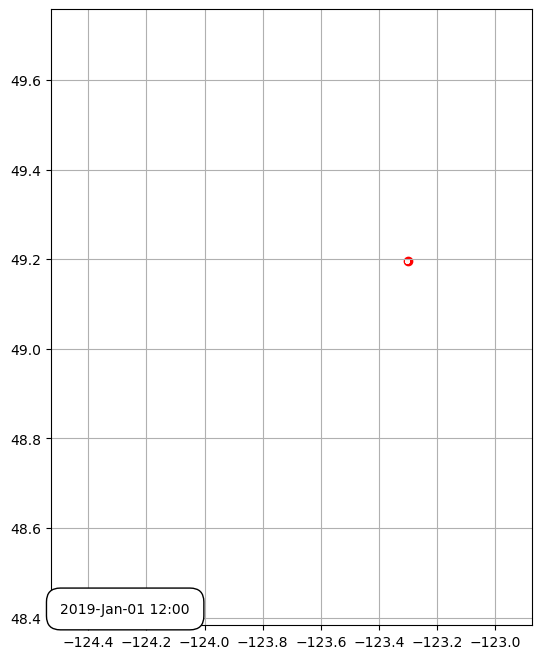

In [9]:
anim = mapanimation(outfile,clon,clat,fps=10,local=1,HD=0)

f2 = r"/Users/jvalenti/comau2.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f2, writer = FFwriter)

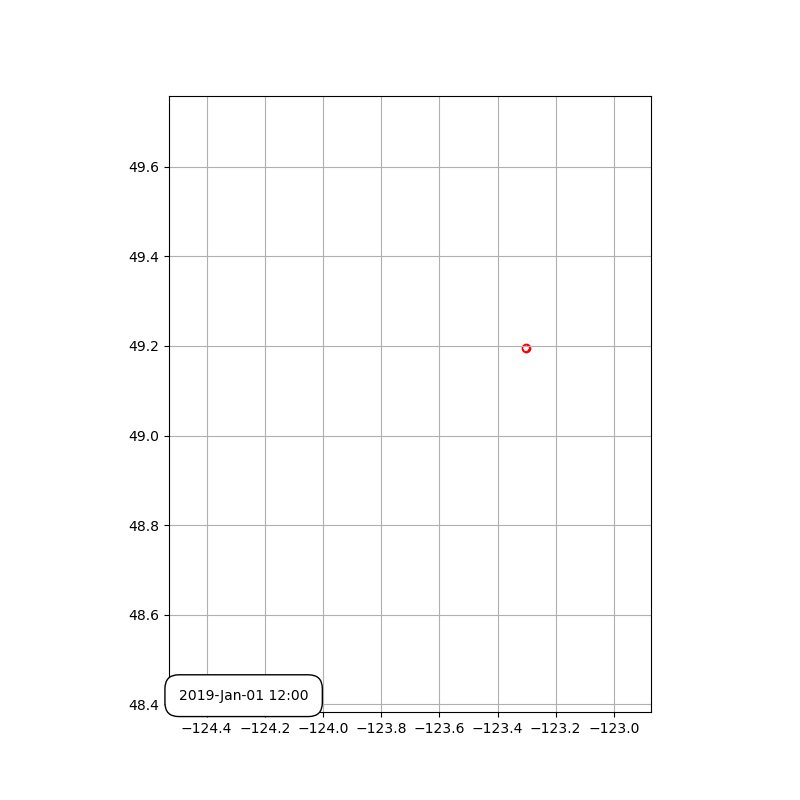

In [10]:
from IPython.display import Image
rc('animation', html='html5')
with open(f2,'rb') as anim:
     display(Image(anim.read()))

In [11]:
ds=data
time = ds.time[0,:]
Lat,Lon,Age,Z = order_data_bytime(ds)

fig = plt.figure(figsize=(8, 8))
lonmin = np.min(ds.lon) -0.5
lonmax = np.max(ds.lon) +0.5
latmin = np.min(ds.lat) -0.5
latmax = np.max(ds.lat) +0.5

<Figure size 800x800 with 0 Axes>

<Figure size 1900x800 with 0 Axes>

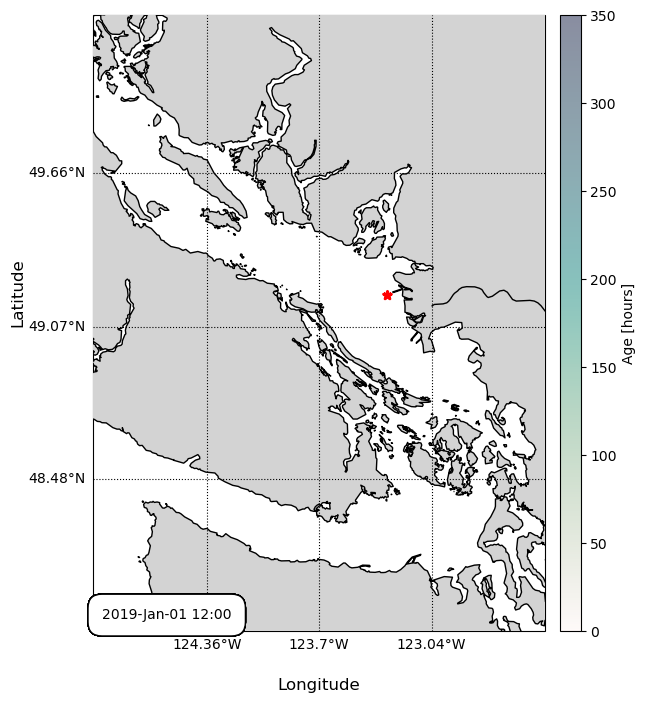

In [12]:
fps = 15
fig = plt.figure(figsize=(19, 8))
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10) 
# Make map
fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('high', edgecolor='k', facecolor='lightgray'),zorder=4)
ax.add_feature(feature.RIVERS, edgecolor='k',zorder=5)
a = ax.scatter(Lon[0], Lat[0],s=4,c=Age[0],cmap=cmocean.cm.tempo,vmin=0,vmax=350,alpha=0.5,zorder=3,transform=crs.PlateCarree())
cbar = fig.colorbar(a, location='right',aspect=30,shrink=1,pad=0.01)
cbar.set_label('Age [hours]')

gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=np.round(np.linspace(lonmin,lonmax,5),2), ylocs=np.round(np.linspace(latmin,latmax,5),2),zorder=5)
gl.top_labels, gl.right_labels = False, False

ax.scatter(clon,clat,c='r', marker='*', linewidth=2,transform=crs.PlateCarree(),zorder=4)    
ax.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

def animate(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss=scatter_particles(ax, 1,1, frames,frames, Lat,Lon,Age)
    t = ax.text(0.02, 0.02, '', color='black', 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'), transform=ax.transAxes,zorder=5)
    tstamp = time[frames].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))

anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(time[:-2]),fps))

f = r"/Users/jvalenti/MOAD/animations/storm2.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

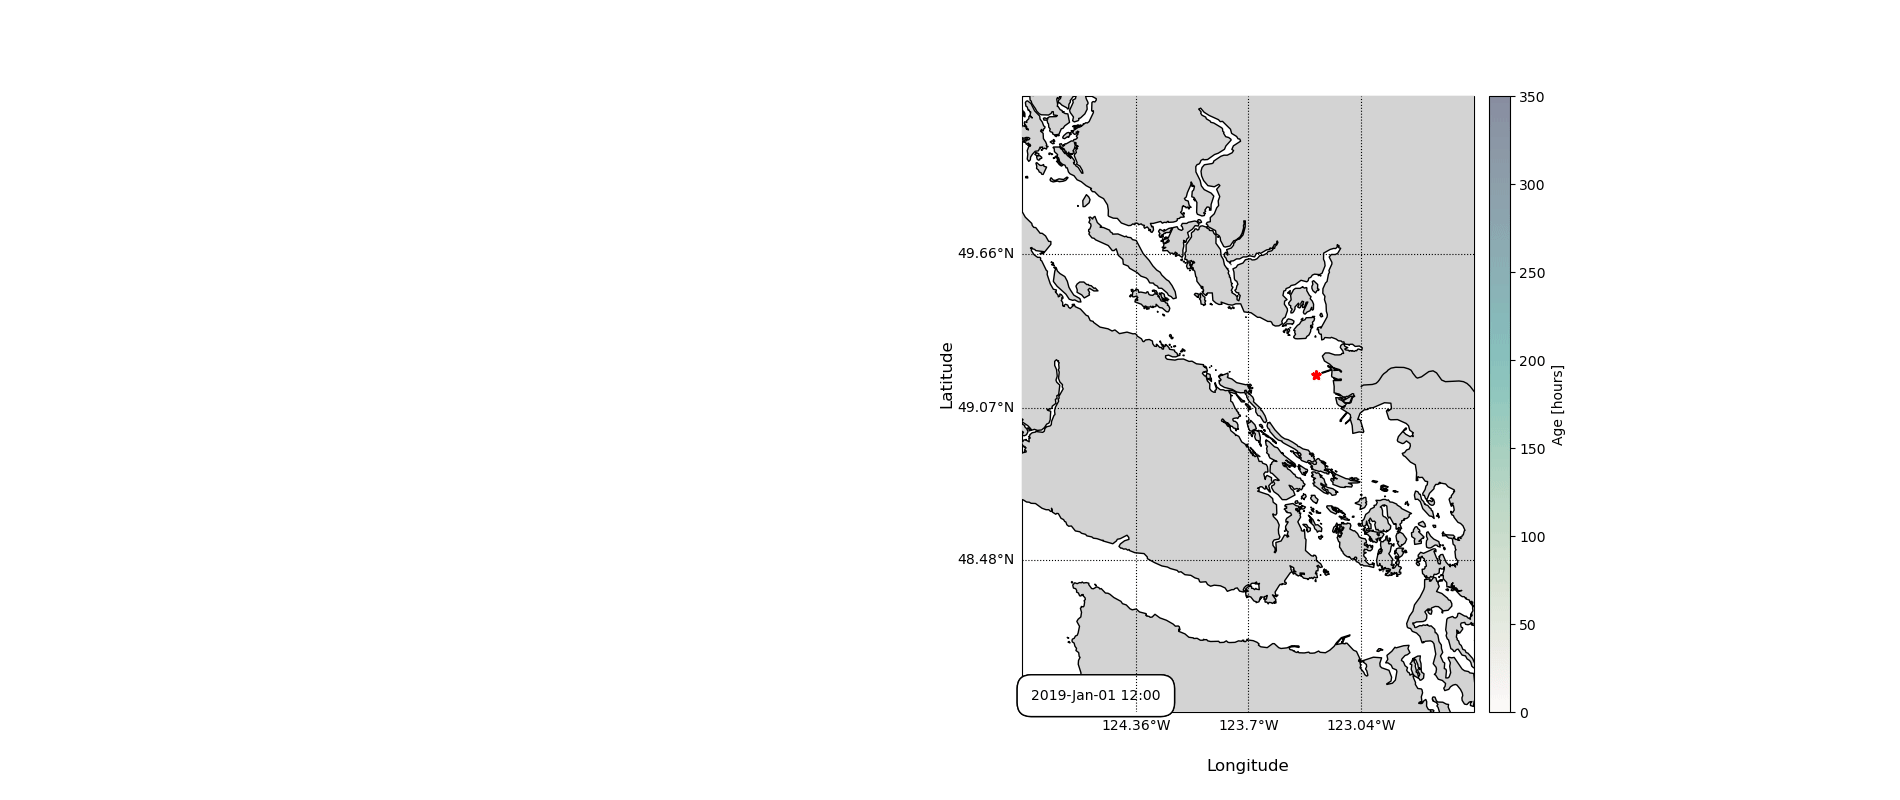

In [13]:
from IPython.display import Image
rc('animation', html='html5')
with open(f,'rb') as anim:
     display(Image(anim.read()))